In [29]:
import os, glob, copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [30]:
# Build label mapping
def build_class_mapping(label_file):
    class_set = set()
    with open(label_file, 'r') as f:
        for line in f:
            _, class_name = line.strip().split(',')
            class_set.add(class_name)
    sorted_classes = sorted(class_set)
    class_to_idx = {name: idx for idx, name in enumerate(sorted_classes)}
    return class_to_idx


In [31]:
# Custom Dataset
class SportsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, class_to_idx=None):
        self.image_dir = os.path.join(root_dir, split, 'images')
        label_file = os.path.join(root_dir, split, 'labels.txt')
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = class_to_idx or {}

        with open(label_file, 'r') as f:
            for line in f:
                image_name, class_name = line.strip().split(',')
                if class_name not in self.class_to_idx:
                    self.class_to_idx[class_name] = len(self.class_to_idx)
                self.image_paths.append(os.path.join(self.image_dir, image_name))
                self.labels.append(self.class_to_idx[class_name])

        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [32]:
# Transforms
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

In [33]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            print(f"💤 EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [34]:
# Dataloaders
def get_dataloaders(root_dir, class_to_idx, batch_size=64):
    train_t, test_t = get_transforms()
    train_ds = SportsDataset(root_dir, 'train', transform=train_t, class_to_idx=class_to_idx)
    val_ds   = SportsDataset(root_dir, 'val', transform=test_t, class_to_idx=class_to_idx)
    test_ds  = SportsDataset(root_dir, 'test', transform=test_t, class_to_idx=class_to_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

In [48]:
# Model
def build_model(num_classes):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    # Unfreeze features[-2] và features[-1]
    for param in model.features[-2:].parameters():
        param.requires_grad = True
    # Unfreeze toàn bộ classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# Train
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, save_path='best_eff_model.pth', patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        print(f"Val Acc: {val_acc:.4f}")

        # Check early stopping
        early_stopping(val_acc)
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered. Training stopped.")
            break

        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, save_path)
            print("✅ Best model saved.")

    model.load_state_dict(best_weights)
    return model


In [36]:
def evaluate_model(model, test_loader, device, class_names=None, show_misclassified=True, max_misclassified=24):
    model.eval()
    all_preds, all_labels = [], []
    misclassified = []  

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            if show_misclassified and class_names is not None:
                for i in range(len(labels)):
                    if preds[i] != labels[i]:
                        misclassified.append((
                            inputs[i].detach().cpu(),
                            preds[i].item(),
                            labels[i].item()
                        ))
        
    # Tính toán các metric
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\n=== Test Results ===")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall   :  {recall:.4f}")
    print(f"F1 Score :  {f1:.4f}\n")
    
    print("=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))
    
    if class_names is not None:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(12, 10))
        disp.plot(cmap='Blues', xticks_rotation=90)
        plt.title("Confusion Matrix", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    if show_misclassified and class_names is not None and misclassified:
        if len(misclassified) > max_misclassified:
            misclassified = random.sample(misclassified, max_misclassified)
        n_images = len(misclassified)
        # Grid cố định: 6 hàng, 4 cột (tổng 24 ô)
        rows, cols = 6, 4
        plt.figure(figsize=(4 * cols, 4 * rows))
        for i in range(n_images):
            img, pred, true = misclassified[i]
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            prob = F.softmax(output, dim=1)
            conf = prob[0][pred].item() * 100
            
            img = img.permute(1, 2, 0).numpy() 
            img = (img - img.min()) / (img.max() - img.min() + 1e-5)
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.text(0.05, 1.02, f"True: {class_names[true]}", transform=ax.transAxes,
                    ha='left', va='bottom', color='blue', fontsize=9, fontweight='bold')
            ax.text(0.95, 1.02, f"Pred: {class_names[pred]} ({conf:.0f}%)", transform=ax.transAxes,
                    ha='right', va='bottom', color='red', fontsize=9, fontweight='bold')
        plt.suptitle("Misclassified Samples", fontsize=22)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [37]:
def predict_image_label(model, img_path, class_names, device):
    # Preprocess giống như khi test/train
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # resize về kích thước chuẩn
        transforms.ToTensor(),          # chuyển thành tensor
        transforms.Normalize(           # normalize giống như lúc training (nếu có)
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    # Load ảnh và biến đổi
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]

    # Dự đoán
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)
    
    # Kết quả
    predicted_class = class_names[pred.item()]
    confidence_percent = conf.item() * 100
    return predicted_class, confidence_percent


In [55]:
# 1. Thiết lập
root_dir = '/kaggle/input/sport-img/dataset'
label_path = os.path.join(root_dir, 'train', 'labels.txt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Đang sử dụng thiết bị:", device)

# Mapping và số lớp
class_to_idx = build_class_mapping(label_path)
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_to_idx)

# Load Data
train_loader, val_loader, test_loader = get_dataloaders(root_dir, class_to_idx, batch_size=128)

# Xây model
model = build_model(num_classes).to(device)

Đang sử dụng thiết bị: cuda


In [56]:
model = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=25,
    save_path='best_eff_model.pth'
)


Epoch 1/25


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Train Loss: 2.6802 | Acc: 0.0951


Val Acc: 0.2037
✅ Best model saved.

Epoch 2/25


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Train Loss: 2.5339 | Acc: 0.2480


Val Acc: 0.4333
✅ Best model saved.

Epoch 3/25


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]

Train Loss: 2.4063 | Acc: 0.3914


Val Acc: 0.5296
✅ Best model saved.

Epoch 4/25


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Train Loss: 2.2688 | Acc: 0.4810


Val Acc: 0.5889
✅ Best model saved.

Epoch 5/25


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

Train Loss: 2.1375 | Acc: 0.5475


Val Acc: 0.6333
✅ Best model saved.

Epoch 6/25


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Train Loss: 1.9979 | Acc: 0.5935


Val Acc: 0.6704
✅ Best model saved.

Epoch 7/25


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

Train Loss: 1.8420 | Acc: 0.6450


Val Acc: 0.6852
✅ Best model saved.

Epoch 8/25


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

Train Loss: 1.7312 | Acc: 0.6410


Val Acc: 0.7148
✅ Best model saved.

Epoch 9/25


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

Train Loss: 1.6033 | Acc: 0.6609


Val Acc: 0.7444
✅ Best model saved.

Epoch 10/25


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

Train Loss: 1.5006 | Acc: 0.6759


Val Acc: 0.7481
✅ Best model saved.

Epoch 11/25


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Train Loss: 1.4290 | Acc: 0.6886


Val Acc: 0.7778
✅ Best model saved.

Epoch 12/25


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

Train Loss: 1.3292 | Acc: 0.7219


Val Acc: 0.8074
✅ Best model saved.

Epoch 13/25


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

Train Loss: 1.2493 | Acc: 0.7250


Val Acc: 0.8037
💤 EarlyStopping counter: 1/5

Epoch 14/25


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

Train Loss: 1.1737 | Acc: 0.7330


Val Acc: 0.8037
💤 EarlyStopping counter: 2/5

Epoch 15/25


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

Train Loss: 1.1081 | Acc: 0.7409


Val Acc: 0.8148
✅ Best model saved.

Epoch 16/25


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

Train Loss: 1.0603 | Acc: 0.7456


Val Acc: 0.8074
💤 EarlyStopping counter: 1/5

Epoch 17/25


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]

Train Loss: 0.9638 | Acc: 0.7829


Val Acc: 0.8185
✅ Best model saved.

Epoch 18/25


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

Train Loss: 0.9905 | Acc: 0.7417


Val Acc: 0.8111
💤 EarlyStopping counter: 1/5

Epoch 19/25


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

Train Loss: 0.9150 | Acc: 0.7781


Val Acc: 0.8185

Epoch 20/25


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Train Loss: 0.8958 | Acc: 0.7773


Val Acc: 0.8185

Epoch 21/25


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]

Train Loss: 0.8691 | Acc: 0.7813


Val Acc: 0.8296
✅ Best model saved.

Epoch 22/25


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

Train Loss: 0.7984 | Acc: 0.7908


Val Acc: 0.8259
💤 EarlyStopping counter: 1/5

Epoch 23/25


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

Train Loss: 0.7824 | Acc: 0.8019


Val Acc: 0.8333
✅ Best model saved.

Epoch 24/25


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

Train Loss: 0.7589 | Acc: 0.8082


Val Acc: 0.8444
✅ Best model saved.

Epoch 25/25


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]

Train Loss: 0.7159 | Acc: 0.8336


Val Acc: 0.8444


In [53]:
# load model từ file pth
model.load_state_dict(torch.load("/kaggle/working/best_eff_model.pth"))

/tmp/ipykernel_31/1460333490.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_eff_model.pth"))


<All keys matched successfully>


=== Test Results ===
Accuracy :  0.8125
Precision:  0.8317
Recall   :  0.8242
F1 Score :  0.8201

=== Classification Report ===
               precision    recall  f1-score   support

      archery       0.89      0.89      0.89        18
    athletics       0.89      0.47      0.62        17
    badminton       0.60      0.75      0.67        12
     baseball       0.92      0.79      0.85        14
   basketball       0.90      0.73      0.81        26
       boxing       0.92      0.92      0.92        12
      cycling       0.73      0.89      0.80        18
equestrianism       1.00      1.00      1.00        16
         golf       0.86      1.00      0.92        12
       skiing       0.85      0.94      0.89        18
       soccer       0.67      0.81      0.73        27
      surfing       0.88      0.94      0.91        16
     swimming       0.94      0.80      0.86        20
       tennis       0.70      0.70      0.70        23
   volleyball       0.74      0.74      0.74 

<Figure size 1200x1000 with 0 Axes>

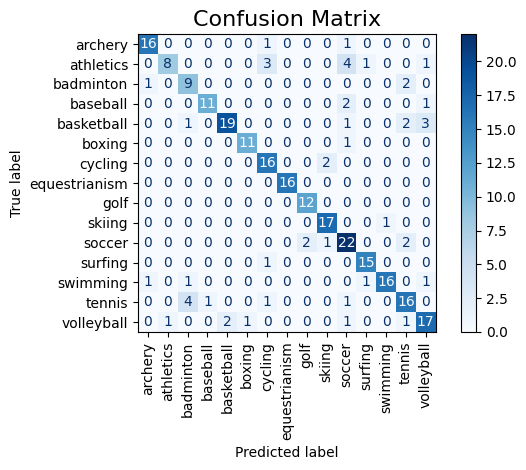

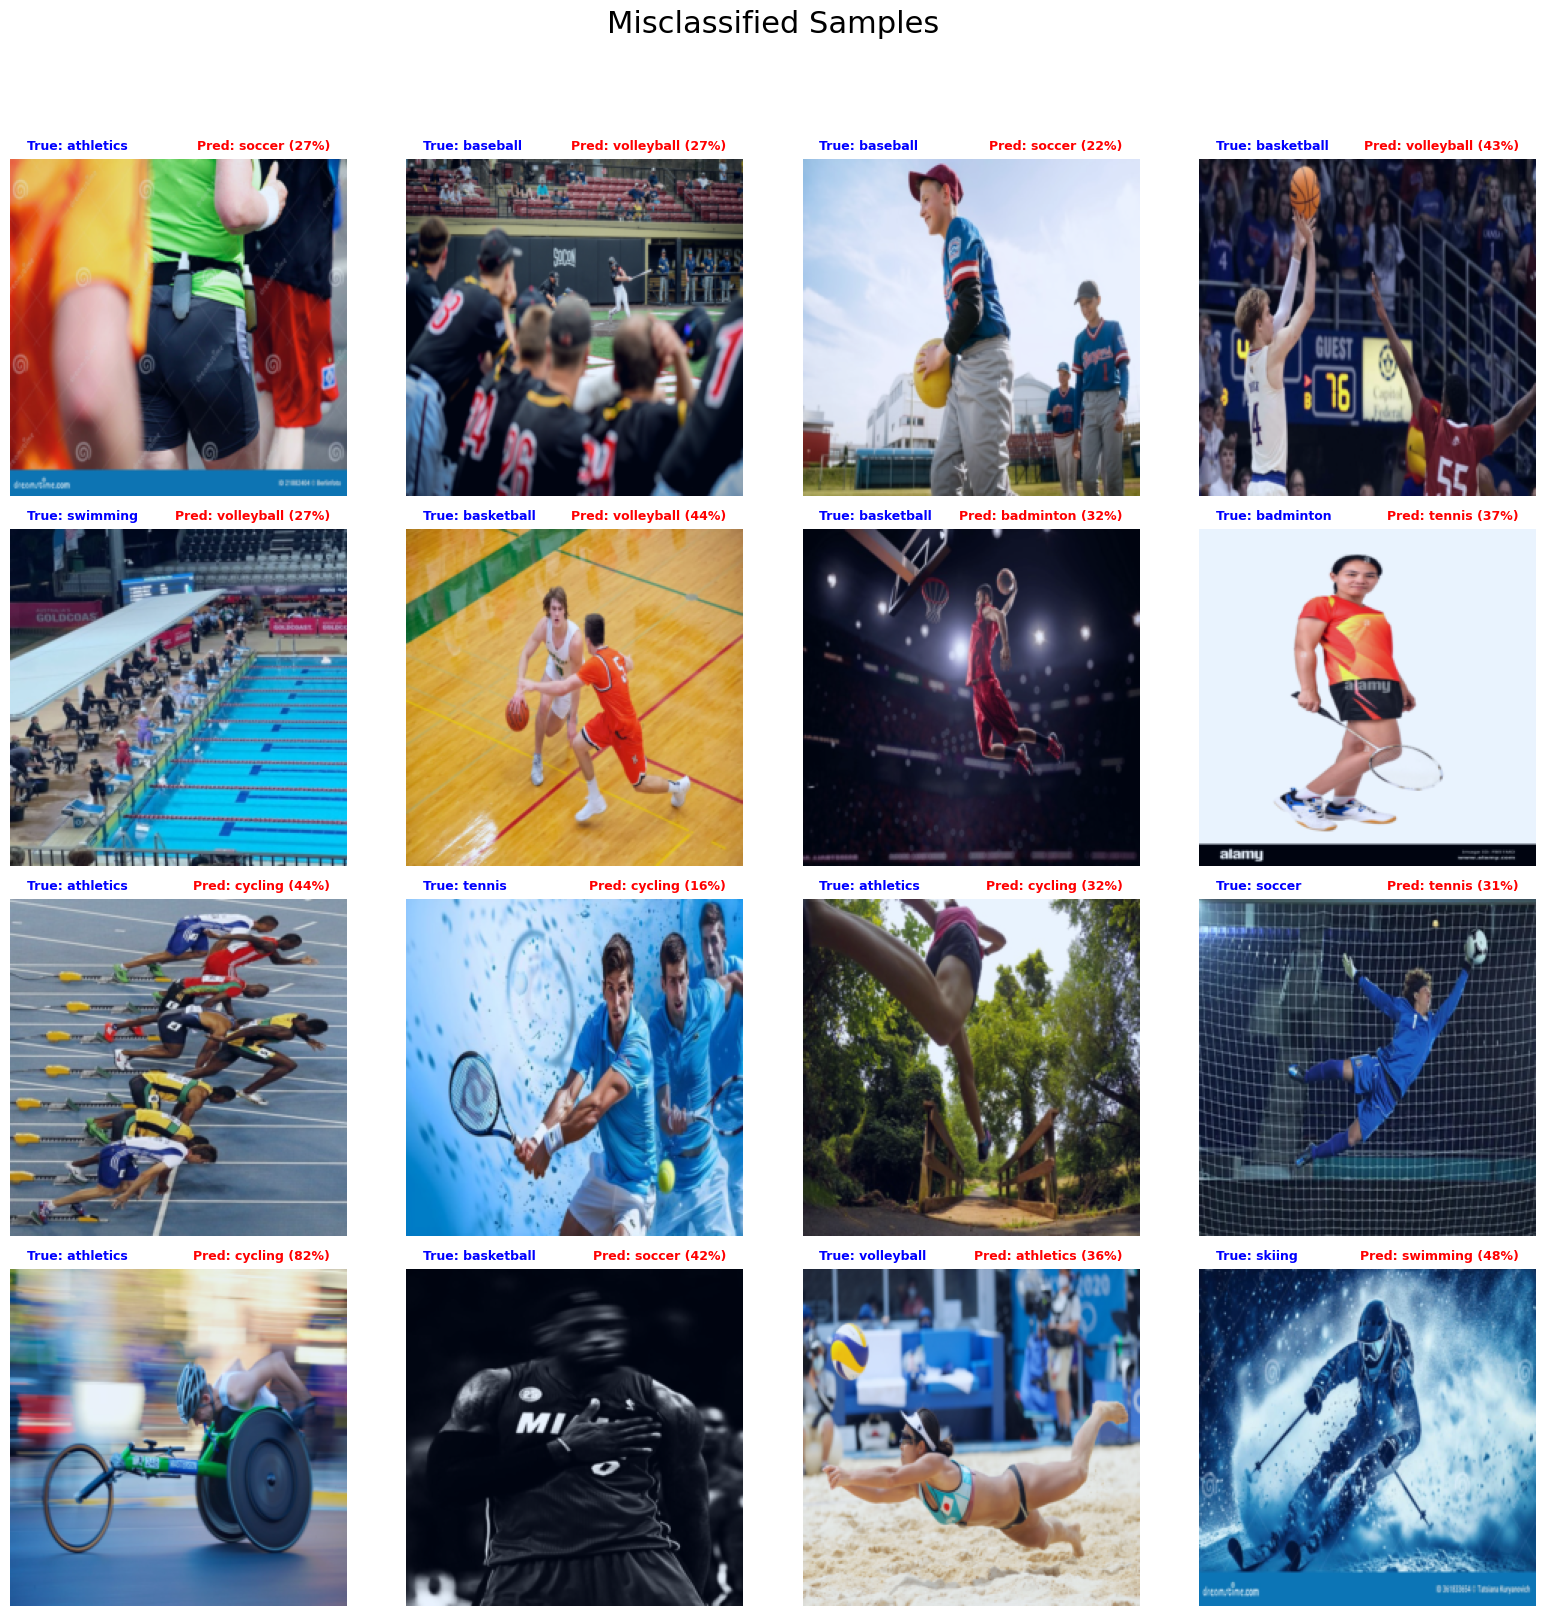

In [57]:
evaluate_model(model, test_loader, device, class_names=class_names, show_misclassified=True, max_misclassified=16)